In [114]:
import pandas as pd
from datetime import datetime as dt, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [115]:
data = pd.read_csv(r"data\bustabit.csv")
data.head()

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
0,14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20T19:44:19Z
1,10676217,3343882,znay22,3,NaN,NaN,NaN,1.40,2016-11-14T14:21:50Z
2,15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23T06:39:15Z
3,25732127,3429241,sanya1206,10,NaN,NaN,NaN,1.63,2016-12-08T18:13:55Z
4,17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27T08:14:48Z


In [116]:
data.tail()

,Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
49995,21345100,3406167,ElenaV,4,NaN,NaN,NaN,4.80,2016-12-02T05:00:57Z
49996,1461408,3302415,Sandboxx,3000,1.04,0.0,120.00,5.03,2016-11-02T19:01:58Z
49997,19704592,3398419,Ferreck,1,NaN,NaN,NaN,1.06,2016-11-29T23:48:11Z
49998,20075463,3400278,ugneri,68,1.33,0.0,22.44,19.00,2016-11-30T12:29:56Z
49999,14739654,3369631,ALIEN_SULACO,300,1.30,0.0,90.00,2.38,2016-11-21T20:20:47Z


In [117]:
data['PlayDate'] = pd.to_datetime(data['PlayDate'])

In [118]:
latest_date = data['PlayDate'].max()
print(latest_date)
reference_date = latest_date + pd.Timedelta(days=1)

2016-12-10 20:09:12+00:00


In [119]:
rfm = data.groupby('Username').agg({
    'PlayDate' : lambda x: (reference_date - x.max()).days,
    'Id': 'count',
    'Bet': 'sum'
}).reset_index()

In [120]:
rfm.columns = ['Username', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,Username,Recency,Frequency,Monetary
0,----------------,37,3,31
1,--dilib--,38,8,1686
2,-31337-,1,4,130
3,-Nothing-,5,65,20987
4,-Tachyon,39,5,5124


In [121]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75], numeric_only=True)

def RFMScore(x, p, d):
    if p == "Recency":
        if x <= d[p][0.25]:
            return 4
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1
    else:
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

In [122]:
rfm['R'] = rfm['Recency'].apply(RFMScore, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(RFMScore, args=('Frequency', quantiles))
rfm['M'] = rfm['Monetary'].apply(RFMScore, args=('Monetary', quantiles))

In [123]:
rfm.head()

,Username,Recency,Frequency,Monetary,R,F,M
0,----------------,37,3,31,1,2,1
1,--dilib--,38,8,1686,1,3,3
2,-31337-,1,4,130,4,3,2
3,-Nothing-,5,65,20987,4,4,4
4,-Tachyon,39,5,5124,1,3,3


In [124]:
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Username,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,----------------,37,3,31,1,2,1,121,4
1,--dilib--,38,8,1686,1,3,3,133,7
2,-31337-,1,4,130,4,3,2,432,9
3,-Nothing-,5,65,20987,4,4,4,444,12
4,-Tachyon,39,5,5124,1,3,3,133,7


In [125]:
segment_labels = ['Red', 'Amber', 'Green']

In [126]:
def assign_segment(row) :
    R, F, M = row['R'], row['F'], row['M']
    if R <= 2 and F >= 4 and M >= 4:
        return 'Red'
    elif R <= 3 and F >= 3 and M >= 3:
        return 'Amber'
    else:
        return 'Green'

rfm['Risk'] = rfm.apply(assign_segment, axis = 1)

In [127]:
rfm.head()

,Username,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Risk
0,----------------,37,3,31,1,2,1,121,4,Green
1,--dilib--,38,8,1686,1,3,3,133,7,Amber
2,-31337-,1,4,130,4,3,2,432,9,Green
3,-Nothing-,5,65,20987,4,4,4,444,12,Green
4,-Tachyon,39,5,5124,1,3,3,133,7,Amber


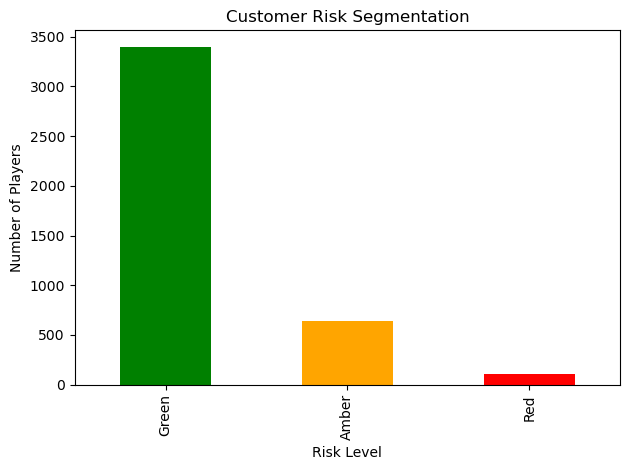

In [ ]:
rfm['Risk'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Customer Risk Segmentation')
plt.xlabel('Risk Level')
plt.ylabel('Number of Players')
plt.tight_layout()
plt.savefig('risk_bar')

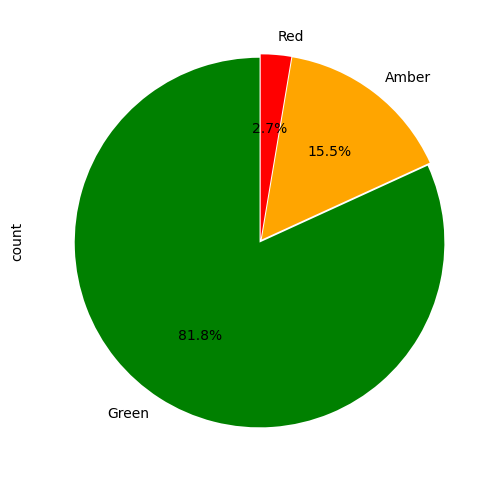

In [129]:
rfm['Risk'].value_counts().plot(kind='pie',colors=['green', 'orange', 'red'], 
    autopct='%1.1f%%',                 
    startangle=90,                     
    explode=[0.01]*3,                 
    figsize=(6, 6)                   
)
plt.savefig('risk_pie')

In [130]:
def assign_loyalty(row):
    R, F, M = row['R'], row['F'], row['M']
    if R >= 4 and F >= 4 and M >= 4:
        return 'VIP'
    elif F >= 4 and R >= 3:
        return 'Loyal Customers'
    elif R >= 4 and F <= 2:
        return 'New'
    else:
        return 'Casual Players'

rfm['Loyalty_Segment'] = rfm.apply(assign_loyalty, axis=1)

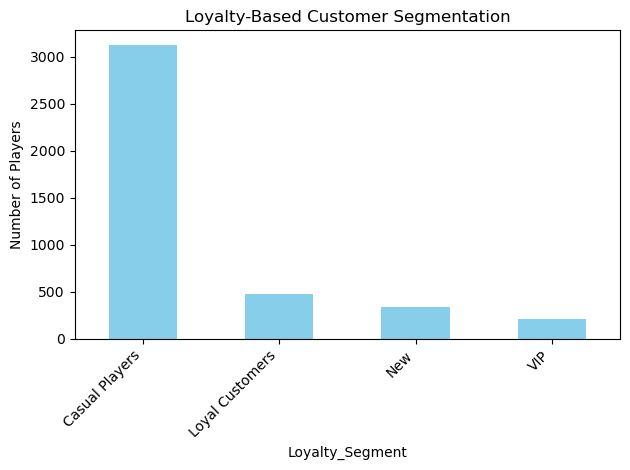

<Figure size 640x480 with 0 Axes>

In [131]:
rfm['Loyalty_Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Loyalty-Based Customer Segmentation')
plt.ylabel('Number of Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.savefig('loyalty_bar')

In [132]:
dual_counts = rfm.groupby(['Loyalty_Segment', 'Risk']).size().reset_index(name='Count')


In [133]:
fig = px.treemap(dual_counts, path=['Loyalty_Segment', 'Risk'], values='Count', color='Risk',
    color_discrete_map={
        'Green': 'green',
        'Amber': 'orange',
        'Red': 'red'
    },title='Loyalty vs. Risk Segmentation Treemap')

fig.show()
plt.savefig('risk_loyalty_treemap')

<Figure size 640x480 with 0 Axes>

In [134]:
rfm['Risk_Code'] = rfm['Risk'].map({'Green': 1, 'Amber': 2, 'Red': 3})
rfm['Loyalty_Code'] = rfm['Loyalty_Segment'].map({
    'Casual Players': 0,
    'New': 1,
    'Loyal Customers': 2,
    'VIP': 3
})
corr_df = rfm[['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'Risk_Code', 'Loyalty_Code']]


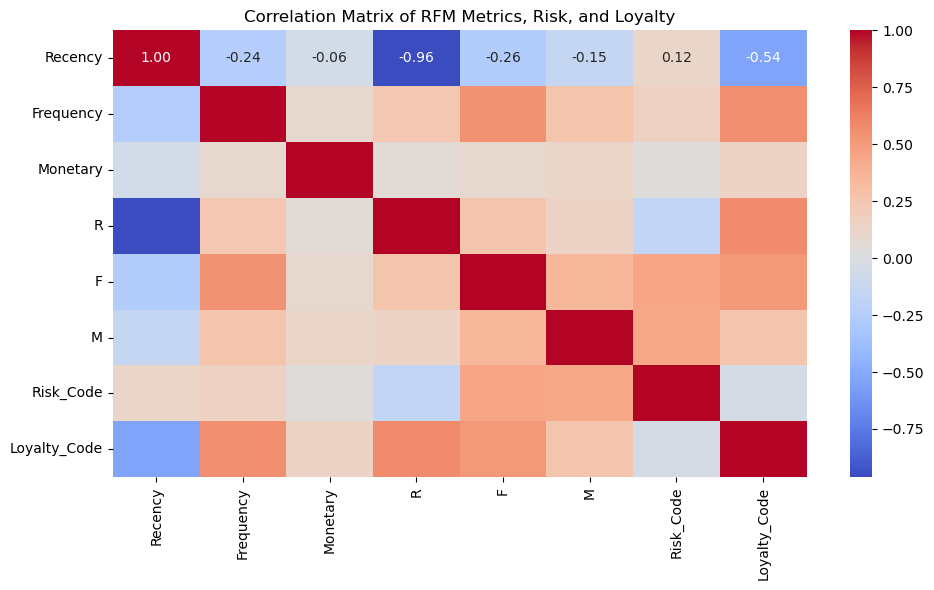

<Figure size 640x480 with 0 Axes>

In [136]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of RFM Metrics, Risk, and Loyalty')
plt.tight_layout()
plt.show()
plt.savefig('corr_matrix')

In [137]:
rfm.head()

,Username,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Risk,Loyalty_Segment,Risk_Code,Loyalty_Code
0,----------------,37,3,31,1,2,1,121,4,Green,Casual Players,1,0
1,--dilib--,38,8,1686,1,3,3,133,7,Amber,Casual Players,2,0
2,-31337-,1,4,130,4,3,2,432,9,Green,Casual Players,1,0
3,-Nothing-,5,65,20987,4,4,4,444,12,Green,VIP,1,3
4,-Tachyon,39,5,5124,1,3,3,133,7,Amber,Casual Players,2,0


In [138]:
rfm.to_csv('rfm.csv', index=False)